# Plots

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib

from ptinsight.common.latency import calculate_latencies
from ptinsight.common.plotting import Plotter, add_relative_time

plotter = Plotter("paper", "../images", "tight")
axis_margin = 0.02

## HSL HFP API

58405979
675.9951273148148
minute_start    2020-06-02 13:07:46+00:00
count                               67350
Name: 156, dtype: object


'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


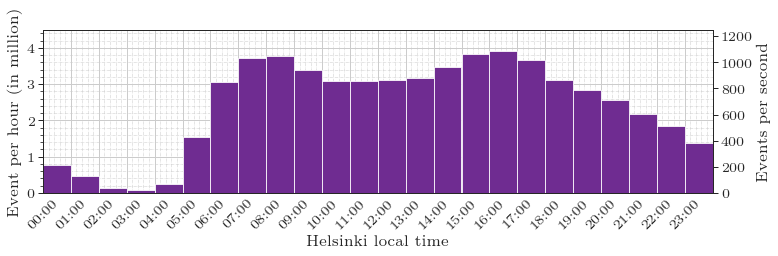

In [2]:
def plot_hsl_daily_event_volume():
    data = pd.read_csv(f"data/daily_event_volume.csv")
    data["minute_start"] = pd.to_datetime(data["minute_start"], utc=True, unit="s")
    
#     data = data.tail(600)
#     data = data.reset_index(drop=True)
    print(data["count"].sum())
    print(data["count"].mean()/60)
    print(data.iloc[data["count"].idxmax()])
    
    time_idx = pd.DatetimeIndex(data["minute_start"]).tz_convert('Europe/Helsinki')
    by_hour = data.groupby(time_idx.hour)["count"].sum()
    hours = range(len(by_hour))
    
    fig, axs = plotter.make_subplots()
    ax = axs[0]
    
    ax2 = ax.twinx()
    ax2.set_ylabel("Events per second")

    ax.bar(hours, by_hour / 1e6, width=1, align="edge")
    ax.set_ylabel("Event per hour (in million)")
    ax.set_xlabel("Helsinki local time")
    ax.set_xlim([0, 24])
    ax.set_xticks(hours)
    ax.set_xticklabels([f"{h:02d}:00" for h in hours], rotation=45, ha="center", va="center_baseline")
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_ylim([0, 4.5])
    
    ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax2.set_yticks([0, 200, 400, 600, 800, 1000, 1200])
    ax2.set_ylim([0, 4.5e6/3600])

    ax.grid(b=True, which="major", linewidth=1.0)
    ax.grid(b=True, which="minor", linewidth=0.5, linestyle="-.")
    
    plotter.save("hsl_daily_event_volume")

plot_hsl_daily_event_volume()

'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


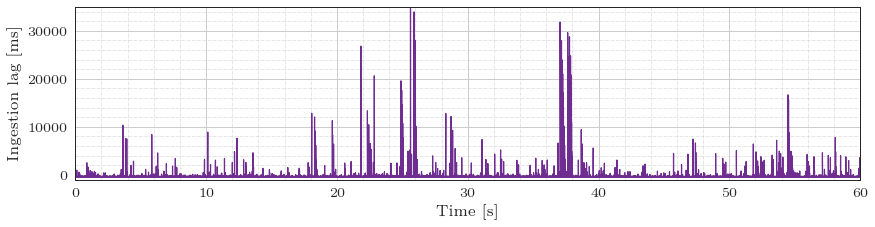

In [3]:
def plot_hsl_ingestion_lag():
    data = pd.read_csv(f"data/ingestion_lag.csv")
    data["time_lag"] = data["ingestion_timestamp"] - data["event_timestamp"]
    add_relative_time(data, "ingestion_timestamp")
    
    fig, axs = plotter.make_subplots()
    ax = axs[0]

    ax.plot(data["t"], data["time_lag"])
#     ax.plot(data["ingestion_timestamp"] - data["ingestion_timestamp"][0], data["event_timestamp"] - data["event_timestamp"][0])

    ax.set_xlim([0, 60])
    ax.set_ylim([-1e3, 35000])
    ax.set_ylabel("Ingestion lag [ms]")
    ax.set_xlabel("Time [s]")

    plotter.format(fig)
    plotter.save(f"hsl_ingestion_lag")
    
plot_hsl_ingestion_lag()

In [4]:
def plot_hsl_timelag_distribution():
    # Plot not used directly only percentiles
    data = pd.read_csv(f"data/ingestion_lag.csv")
    data["time_lag"] = data["ingestion_timestamp"] - data["event_timestamp"]
    add_relative_time(data, "ingestion_timestamp")
    data = data[data["t"] <= 60]
    
    fig, axs = plotter.make_subplots()
    ax = axs[0]

    with pd.option_context('display.max_rows', None):
        print(data["time_lag"].quantile([x/100 for x in range(101)]))
    sb.boxenplot(data["time_lag"], scale="exponential")
#     ax.plot(data["ingestion_timestamp"] - data["ingestion_timestamp"][0], data["event_timestamp"] - data["event_timestamp"][0])

    ax.set_xlim([-2000, 30000])
#     ax.set_ylim([-1e3, 1000])
    ax.set_ylabel("Ingestion lag [ms]")
    ax.set_xlabel("Time [s]")

    plotter.format(fig)
    
# plot_hsl_timelag_distribution()

## Evaluation

All latency measurements are from setup 17 (app/analysis/latency/recordings in ptinsight repo)

In [5]:
jobs = [
    "Vehicle distribution",
    "Delay distribution",
    "Emergency stop detection (stream)",
    "Emergency stop detection (table)"
]
scales = [1, 2, 4, 8, 16, 32, 48, 64]
time_lim = 30 * 60

datas = {}
for scale in scales:
    data = pd.read_csv(f"data/latency_{scale}x.csv")
    
    add_relative_time(data, "ingress_ingestion_timestamp")
    calculate_latencies(data)
    # Trim to 30 min
    data = data[data["t"] <= time_lim]
    
    data.replace("vehicle-distribution", "Vehicle distribution", inplace=True)
    data.replace("delay-distribution", "Delay distribution", inplace=True)
    data.replace("emergency-stop-detection-streaming", "Emergency stop detection (stream)", inplace=True)
    data.replace("emergency-stop-detection-table", "Emergency stop detection (table)", inplace=True)
    
    datas[scale] = data
    
n_data = len(datas)
n_jobs = len(jobs)

latency_cols_no_e2e = ["latency_processing", "latency_ingestion_to_processing", "latency_processing_to_visualization"]
latency_cols = latency_cols_no_e2e + ["latency_end_to_end"]

max_latency = max([data[latency_cols_no_e2e].max().max() for data in datas.values()])
max_t = max([data["t"].max() for data in datas.values()])

'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


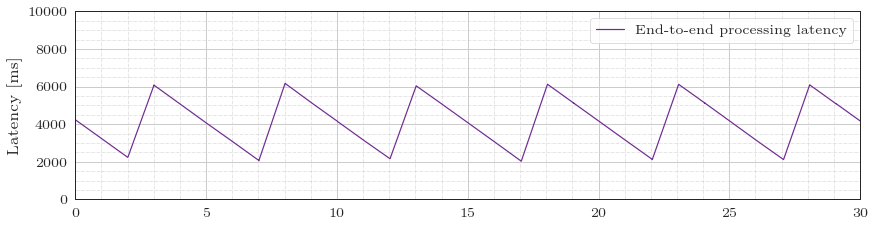

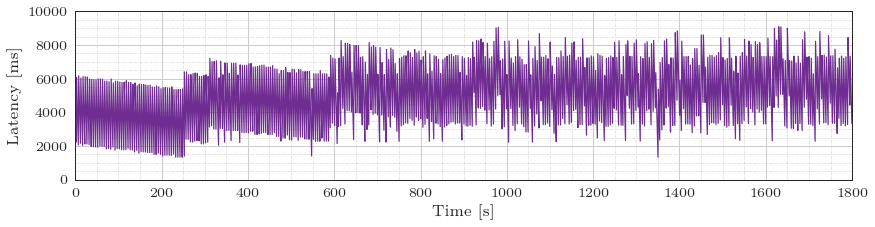

In [6]:
def plot_latency_vehicle_distribution_1x(xlim, ylim, suffix, show_xlabel):
    fig, axs = plotter.make_subplots()
    ax = axs[0]

    data = datas[1][datas[1]["job"] == "Vehicle distribution"]

    ax.plot(data["t"], data["latency_end_to_end"], label="End-to-end processing latency")

    ax.set_xlim([0, xlim])
    ax.set_ylim([0, ylim])
    ax.set_ylabel("Latency [ms]")
    if show_xlabel:
        ax.set_xlabel("Time [s]")
    else:
        ax.legend()

    plotter.format(fig)
    plotter.save(f"latency_vehicle_distribution_1x_{suffix}")
    
plot_latency_vehicle_distribution_1x(30, 10000, "zoomed", False)
plot_latency_vehicle_distribution_1x(time_lim, 10000, "normal", True)

In [7]:
def print_partial_latencies_vehicle_distribution_1x():
    data = datas[1][datas[1]["job"] == "Vehicle distribution"][latency_cols]
    return data.describe()
    
print_partial_latencies_vehicle_distribution_1x()

,latency_processing,latency_ingestion_to_processing,latency_processing_to_visualization,latency_end_to_end
count,3082.000000,3082.000000,3082.000000,3082.000000
mean,5006.115834,6.343933,13.835496,5026.295263
std,1651.635915,3.630599,5.582278,1651.831937
min,1314.000000,2.000000,1.000000,1331.000000
25%,3771.000000,4.000000,10.000000,3786.750000
50%,5089.500000,6.000000,14.000000,5105.500000
75%,6255.750000,7.000000,17.000000,6274.000000
max,9073.000000,38.000000,48.000000,9090.000000


'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


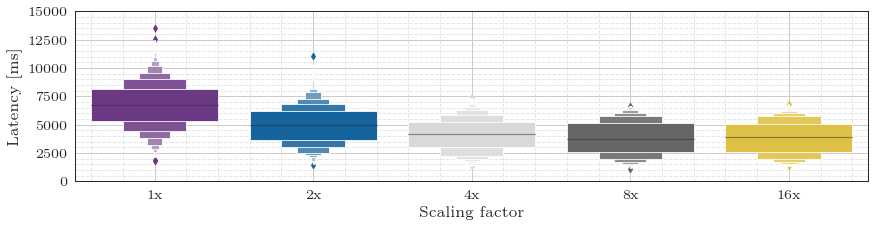

In [8]:
def plot_latency_distribution_by_scale_delay_distribution():
        scales = [1, 2, 4, 8, 16]
    
        fig, axs = plotter.make_subplots()
        ax = axs[0]
        
        data = pd.DataFrame()
        for scale in scales:
            data[scale] = datas[scale][datas[scale]["job"] == "Delay distribution"]["latency_end_to_end"]
        sb.boxenplot(data=data, ax=ax)
        
        ax.set_ylim([0, 15000])
        ax.set_xlabel("Scaling factor")
        ax.set_xticklabels([f"{s}x" for s in scales])
        ax.set_ylabel("Latency [ms]")
        
        plotter.format(fig)
        plotter.save(f"latency_distribution_delay_distribution")
    
plot_latency_distribution_by_scale_delay_distribution()

'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


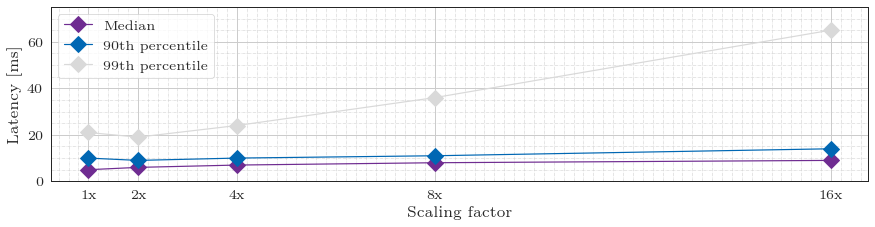

In [9]:
def plot_kafka_latencies_by_scale():
        scales = [1, 2, 4, 8, 16]
    
        fig, axs = plotter.make_subplots()
        ax = axs[0]

        for pct, label in zip([0.5, 0.9, 0.99], ["Median", "90th percentile", "99th percentile"]):
            pcts = {}
            for scale in scales:
                data_for_scale = datas[scale]["latency_ingestion_to_processing"]
                pcts[scale] = data_for_scale.quantile(pct)
            pcts = pd.DataFrame.from_dict(pcts, orient="index")
            ax.plot(pcts.index.values, pcts.iloc[:,0], marker='D', markersize=12, label=label) 
        ax.legend()
        ax.set_ylim([0, 75])
        ax.set_xlabel("Scaling factor")
        ax.set_xticks(scales)
        ax.set_xticklabels([f"{s}x" for s in scales])
        ax.set_ylabel("Latency [ms]")
        
        plotter.format(fig)
        plotter.save(f"kafka_latencies_by_scale")
    
plot_kafka_latencies_by_scale()

## Appendix

'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroma

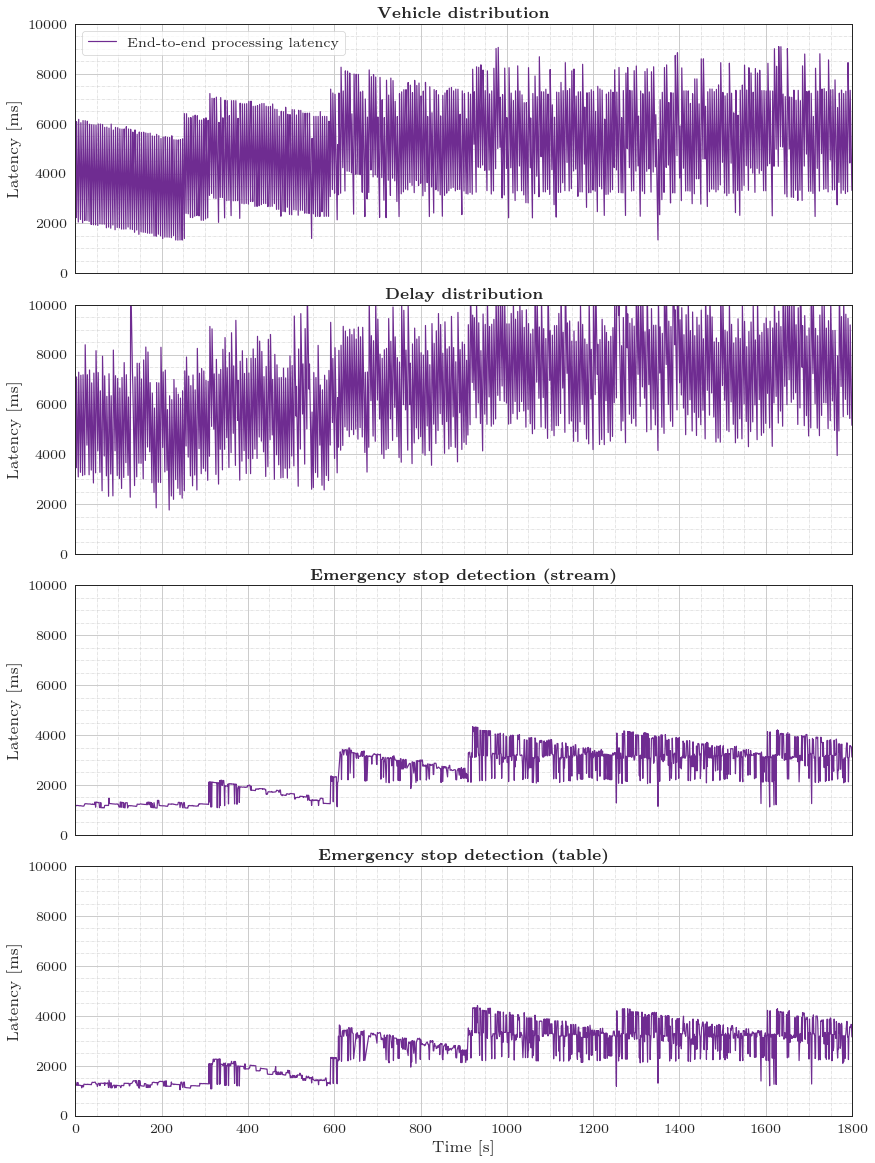

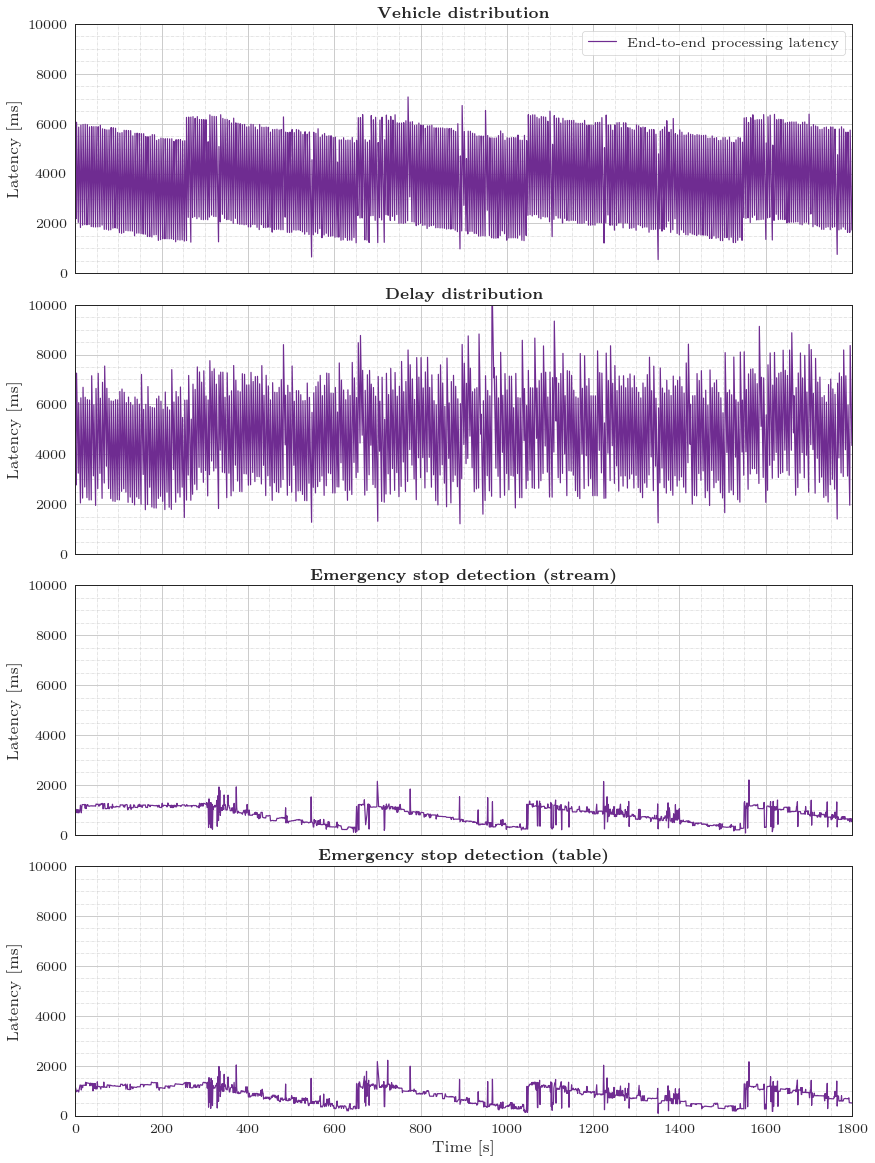

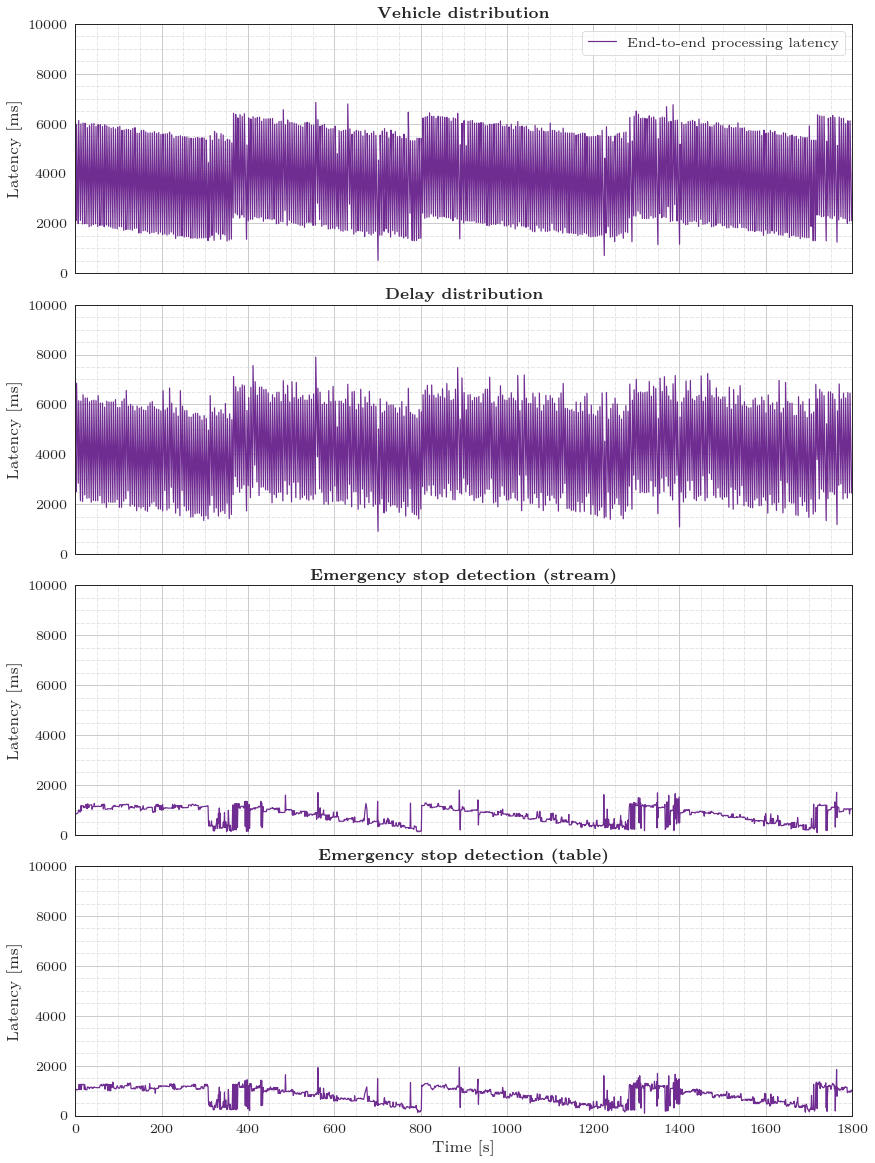

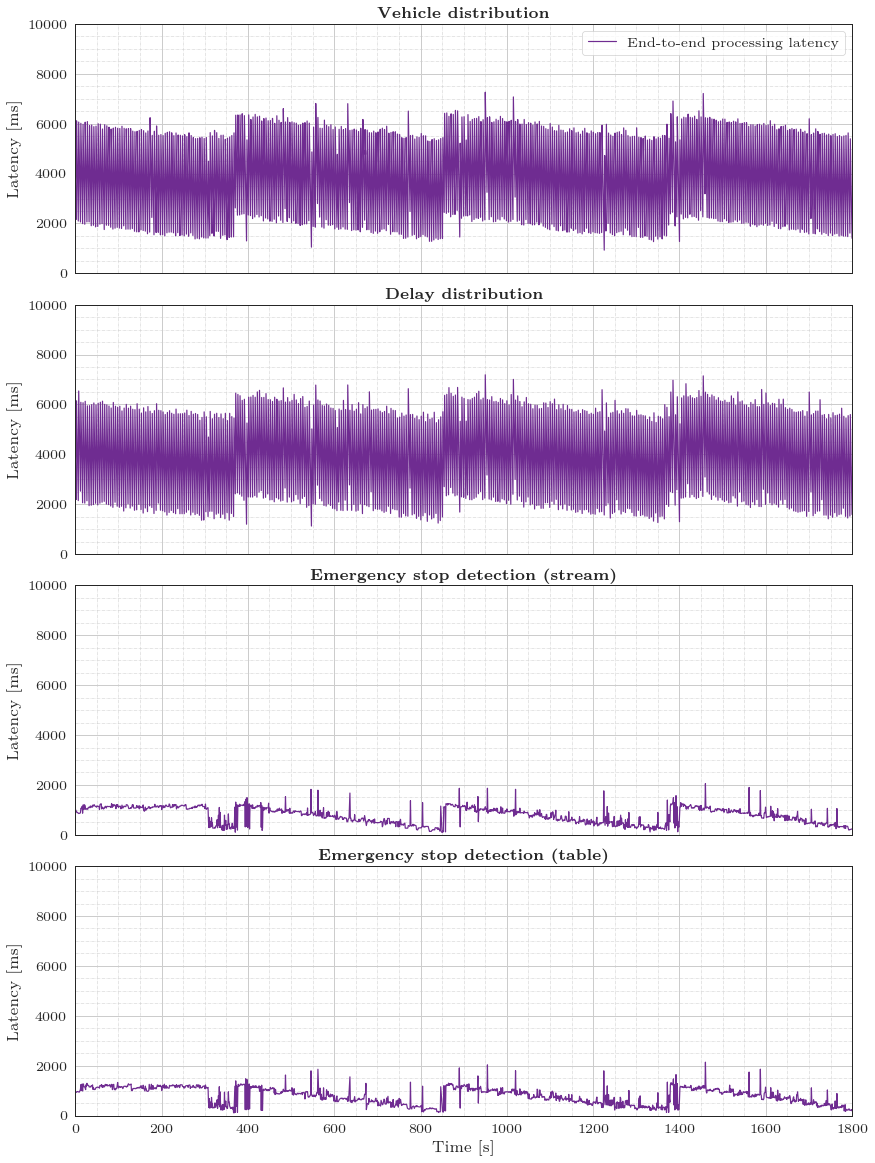

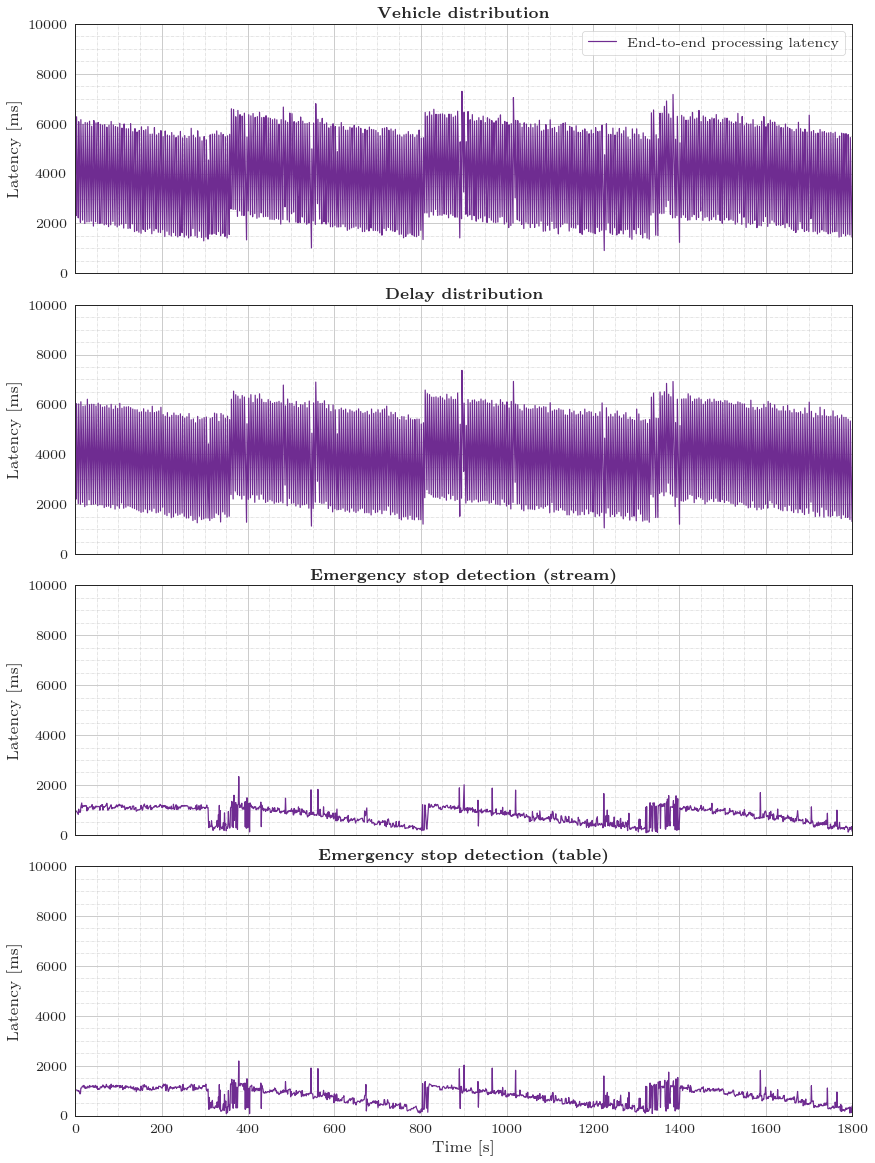

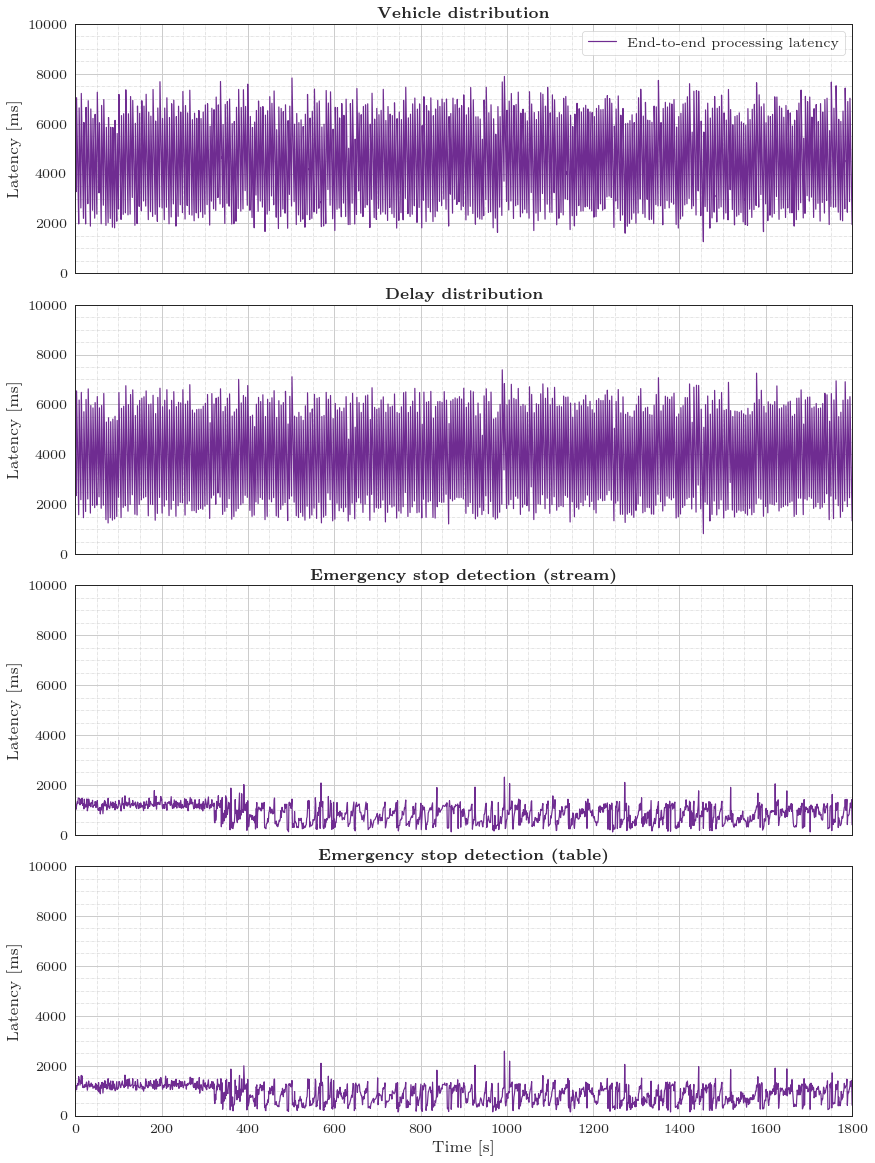

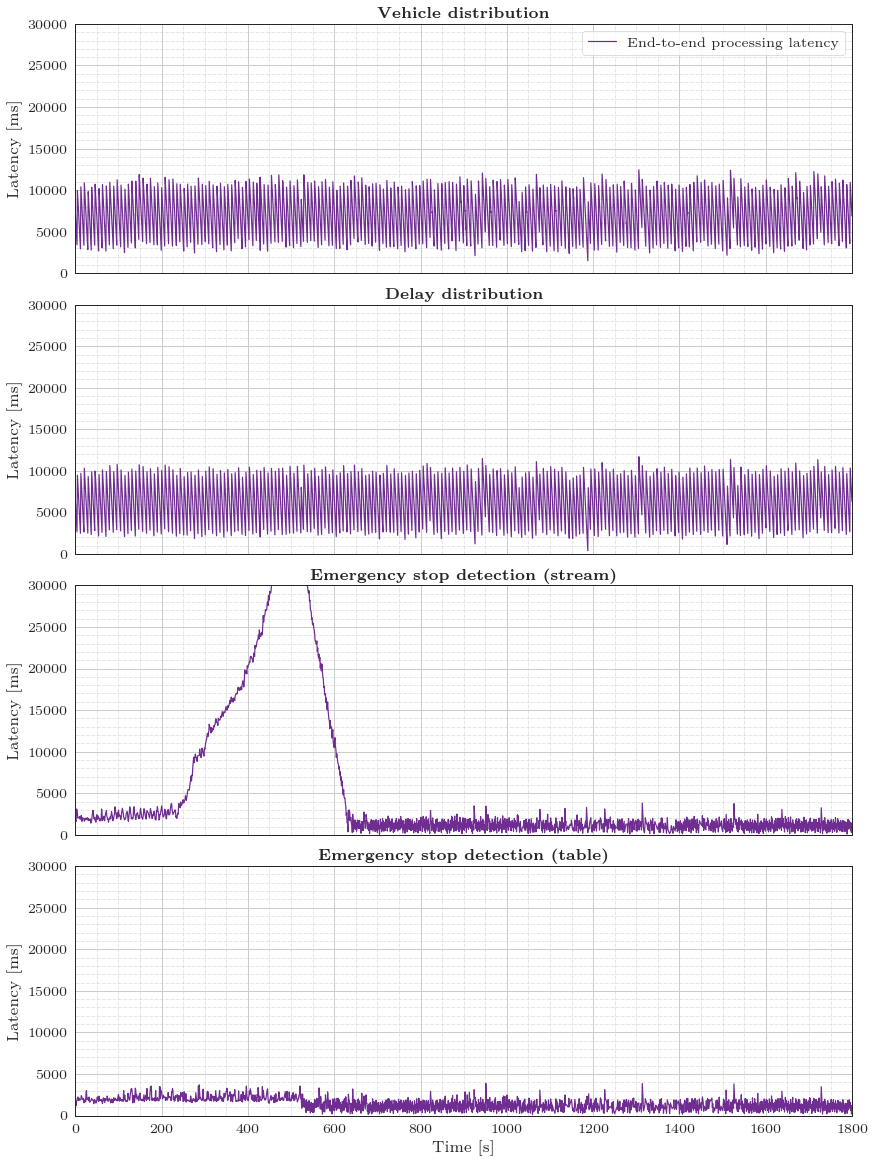

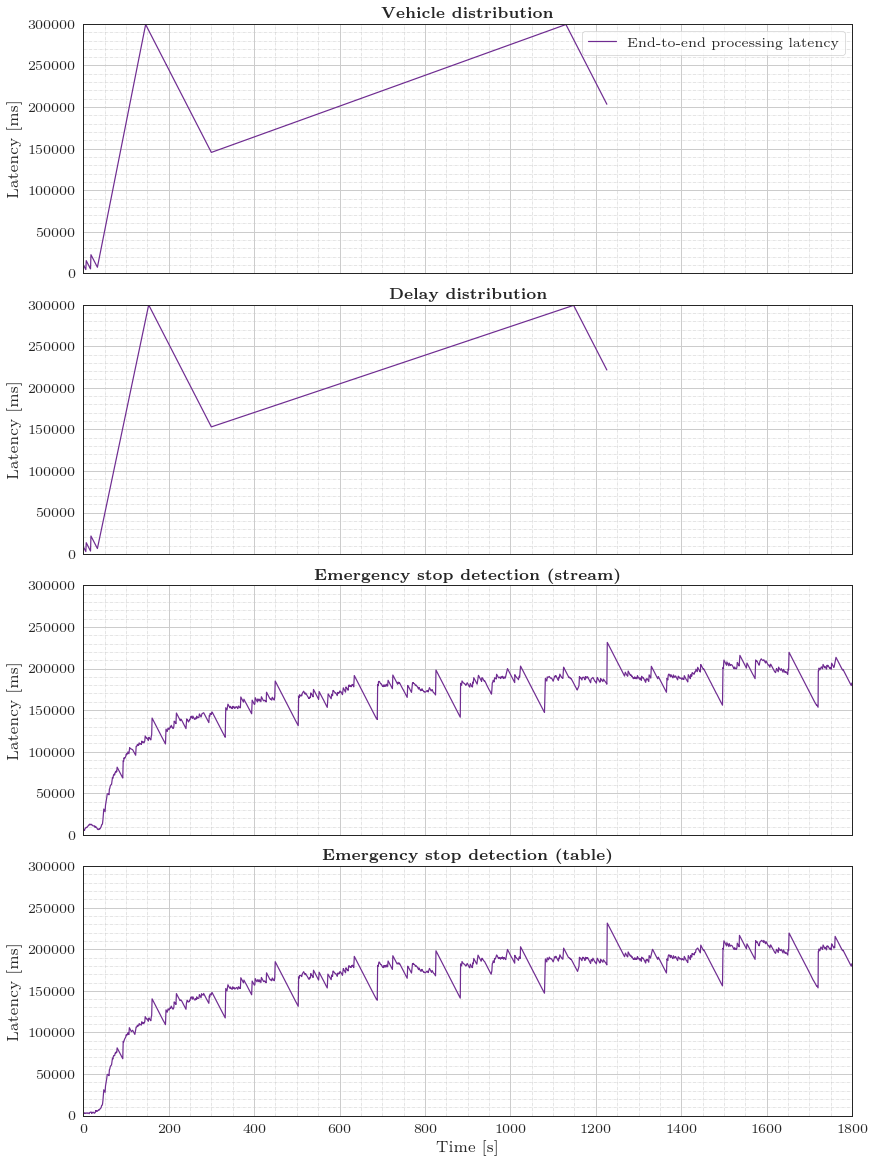

In [10]:
def plot_latency_all(scale, ylim=10):
    fig, axs = plotter.make_subplots(n_jobs, figsize=[12, 4])
    
    for i, ax in enumerate(axs):
        data = datas[scale][datas[scale]["job"] == jobs[i]]

        ax.plot(data["t"], data["latency_end_to_end"], label="End-to-end processing latency")

        ax.set_title(jobs[i])
        ax.set_xlim([0, time_lim])
        ax.set_ylim([0, ylim * 1000])
        ax.set_ylabel("Latency [ms]")
        if i == 0:
            ax.legend()
        if i+1 == len(axs):
            ax.set_xlabel("Time [s]")

    plotter.format(fig)
    plotter.save(f"latency_all_{scale}x")
    
plot_latency_all(1)
plot_latency_all(2)
plot_latency_all(4)
plot_latency_all(8)
plot_latency_all(16)
plot_latency_all(32)
plot_latency_all(48, 30)
plot_latency_all(64, 300)

'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


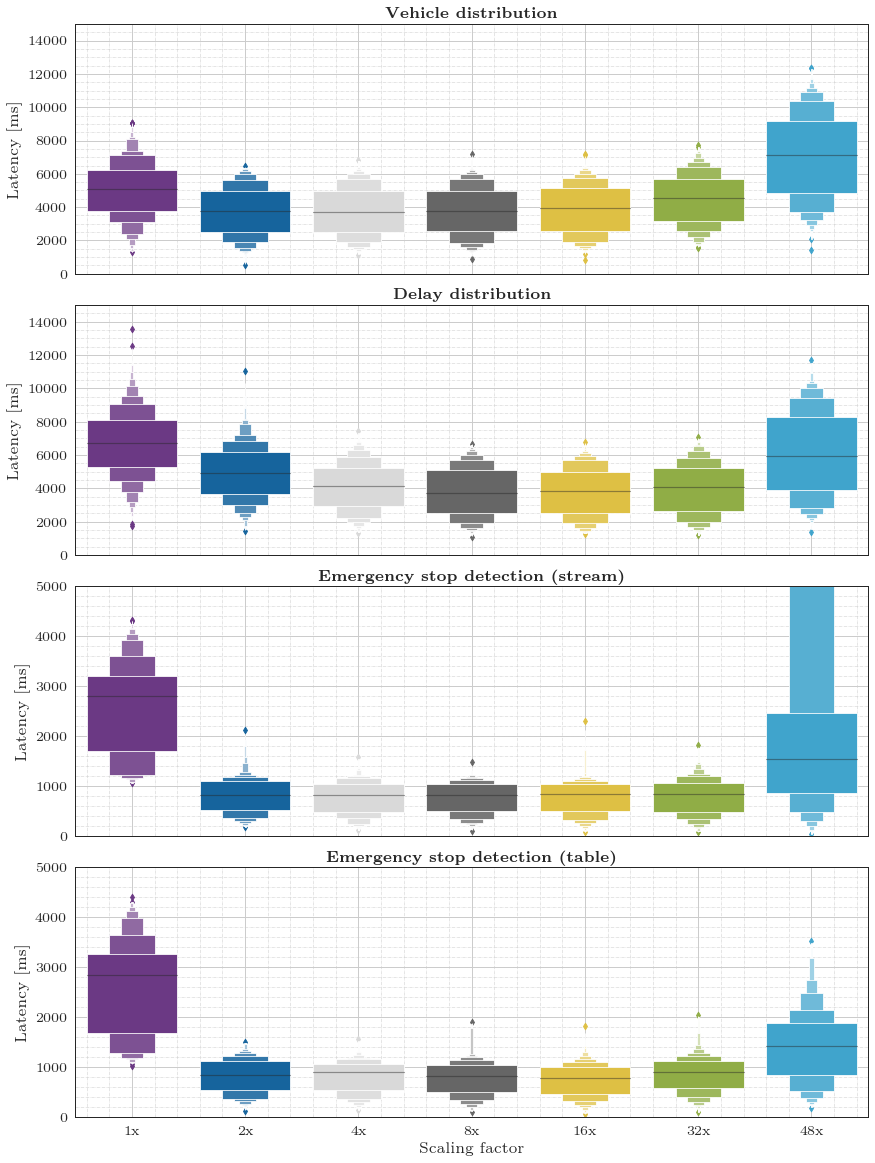

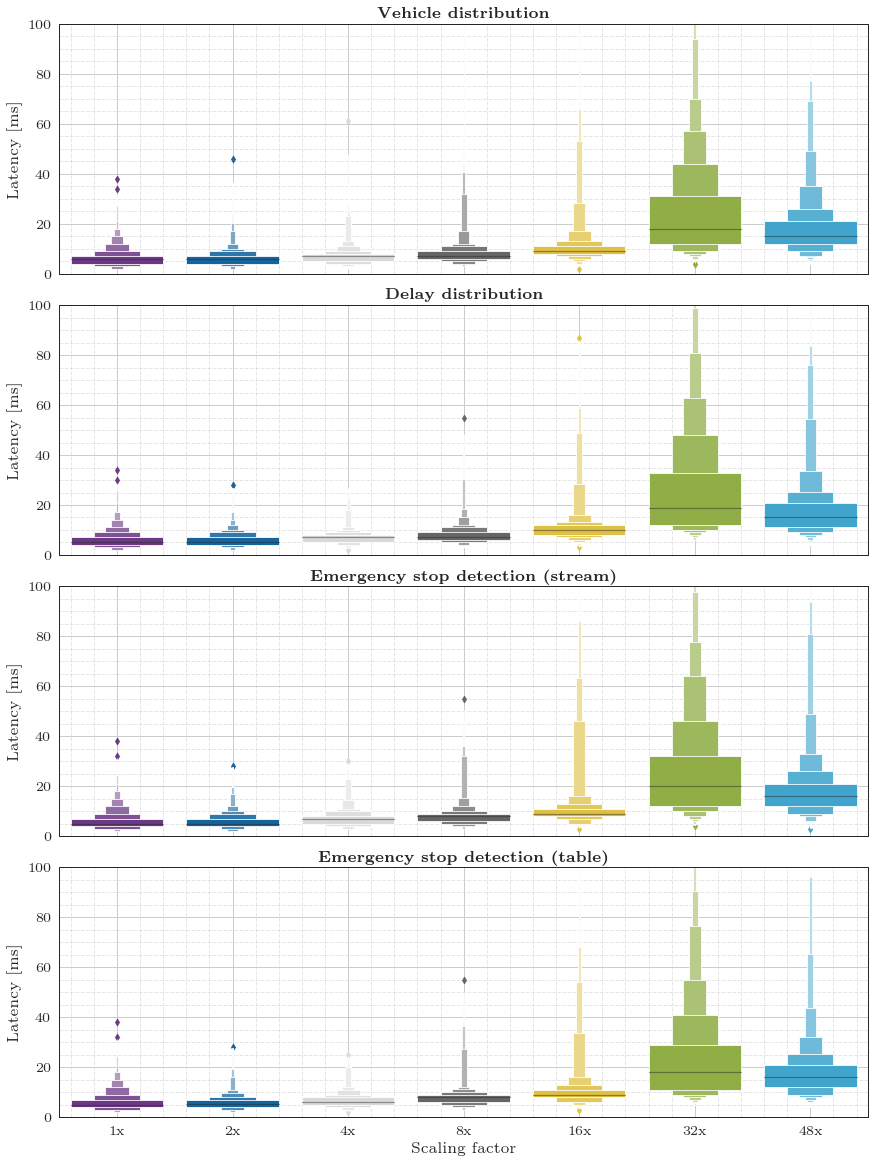

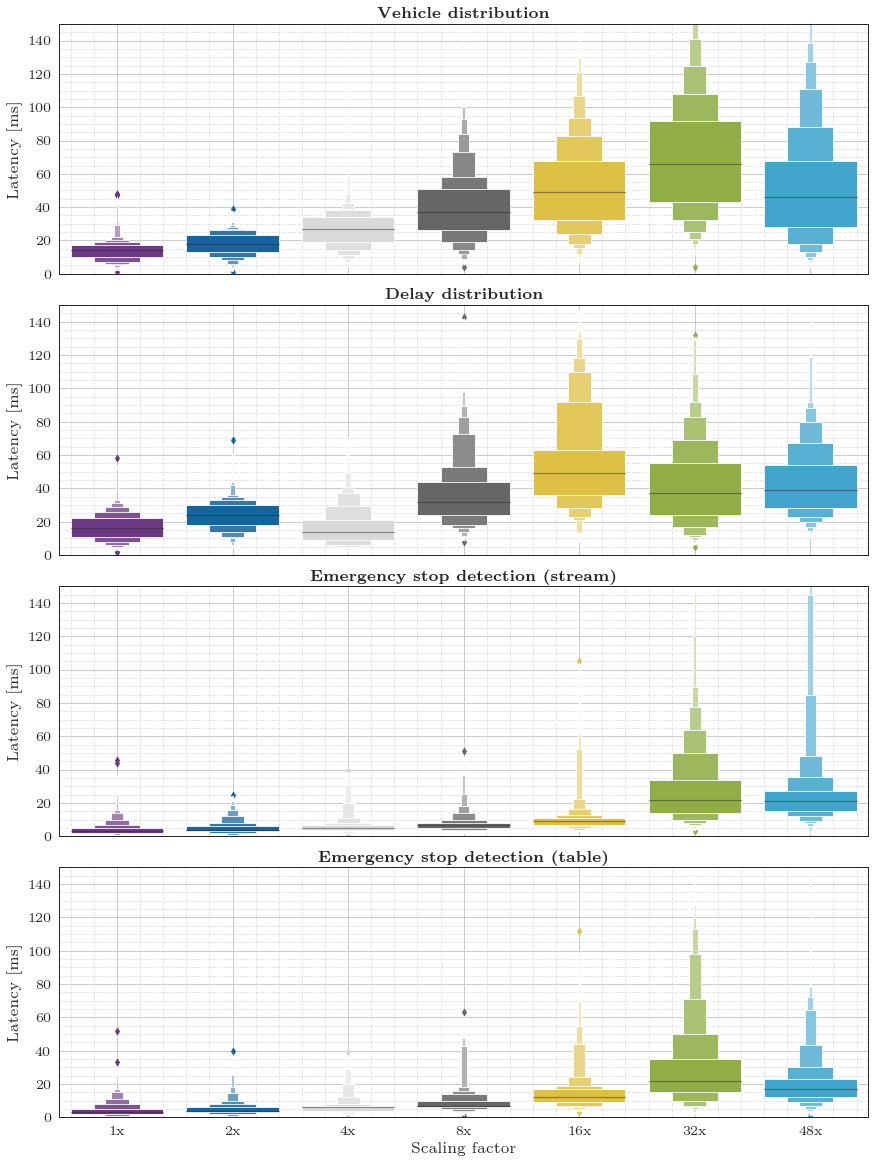

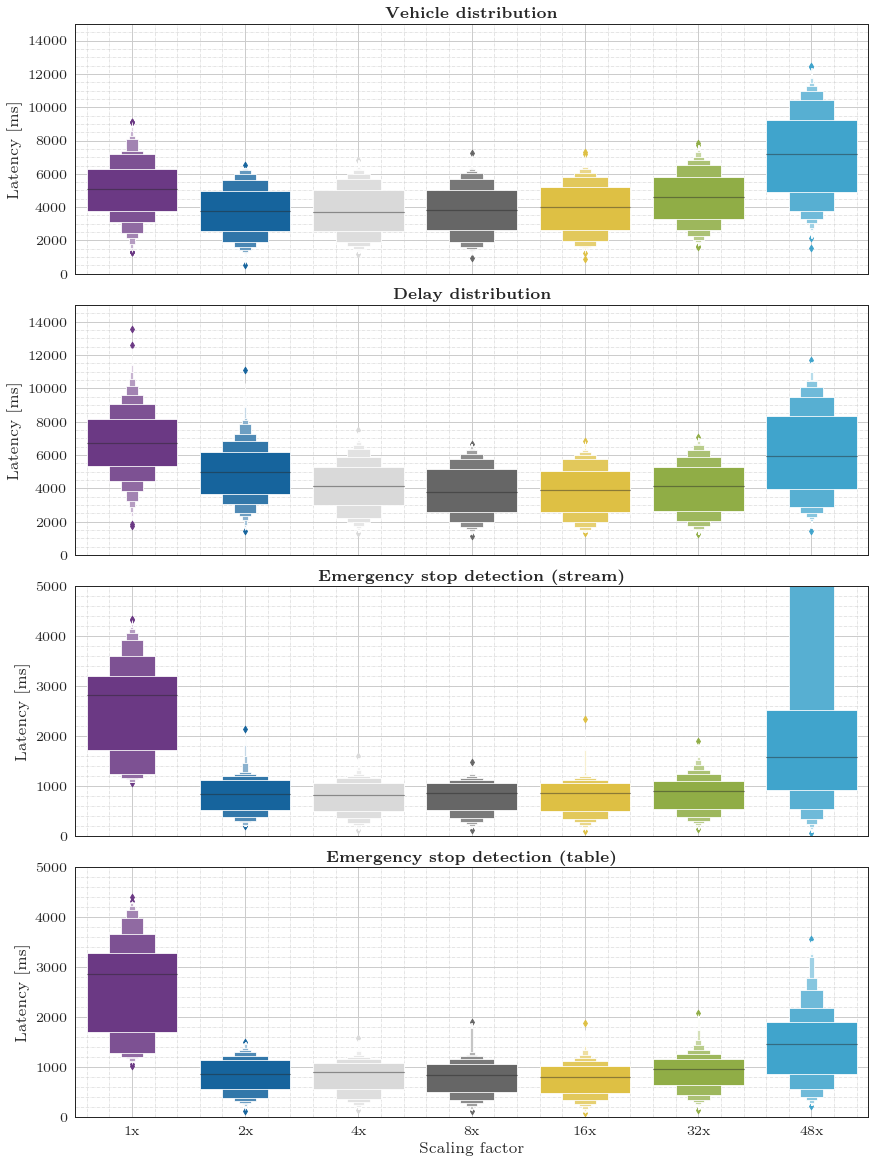

In [11]:
def plot_latency_distribution_by_scale_all(latency_type):
        scales = [1, 2, 4, 8, 16, 32, 48]
    
        fig, axs = plotter.make_subplots(n_jobs, figsize=[12, 4])
        for i, ax in enumerate(axs):
            data = pd.DataFrame()
            for scale in scales:
                data[scale] = datas[scale][datas[scale]["job"] == jobs[i]][latency_type]
            sb.boxenplot(data=data, ax=ax)
        
            ax.set_title(jobs[i])
            
            if latency_type in ["latency_end_to_end", "latency_processing"]:
                if "Emergency" in jobs[i]:
                    ax.set_ylim([0, 5000])
                else:
                    ax.set_ylim([0, 15000])
            elif latency_type == "latency_ingestion_to_processing":
                ax.set_ylim([0, 100])
            else:
                ax.set_ylim([0, 150])
                
            if i+1 == len(axs):
                ax.set_xlabel("Scaling factor")
            ax.set_xticklabels([f"{s}x" for s in scales])
            ax.set_ylabel("Latency [ms]")
        
        plotter.format(fig)
        plotter.save(f"latency_distribution_all_{latency_type}")
    
for latency_type in latency_cols:
    plot_latency_distribution_by_scale_all(latency_type)